# HTML: feature engineering and model training
In this notebook, we focus on getting the data and properly shaping it to extract meaningful features for the model.
Then, we engineer some features that we hope will make the model capture the patterns better.
Finally, we fine tune the hyperparameters and perform model selection to find the best performing model.

## Setup the environment

In [1]:
# Import the needed libraries
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import requests
import re
from bs4 import BeautifulSoup
from workalendar.europe import Finland
import seaborn as sns

# Import the helper file methods
from helper_file import load_data, get_file_paths


Bad key "text.kerning_factor" on line 4 in
C:\Users\ansni\anaconda3\envs\IDS\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Get the data

In [2]:
url = 'https://aineistot.vayla.fi/lam/reports/LAM/'
result = get_file_paths(url)

In [3]:
dfs = []
for url in result:
    d = load_data(url)
    dfs.append(d)
data_set = pd.concat(dfs, ignore_index=True)

In [4]:
data_set.head()

,TMS,Location,Date,Direction,Type,00-01,01-02,02-03,03-04,04-05,...,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-00
0,117,vt1_Munkkiniemi,2019-01-12,1,11 HA-PA,216,186,158,147,117,...,976,974,978,899,829,675,525,362,189,108
1,117,vt1_Munkkiniemi,2019-01-12,1,12 KAIP,0,2,0,1,0,...,5,2,2,4,2,4,1,0,0,0
2,117,vt1_Munkkiniemi,2019-01-12,1,13 Linja-autot,1,2,1,0,2,...,15,8,12,8,11,9,8,5,6,4
3,117,vt1_Munkkiniemi,2019-01-12,1,14 KAPP,1,0,0,0,0,...,0,0,0,0,1,1,1,0,1,1
4,117,vt1_Munkkiniemi,2019-01-12,1,15 KATP,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0


## Preprocessing and basic feature extraction

In [5]:
cal = Finland()
data_set['holiday'] = data_set.Date.apply(lambda x: not cal.is_working_day(x))

In [6]:
id_vars=list(data_set.columns[:5])
id_vars.append(data_set.columns[-1])
value_vars=list(data_set.columns[5:][:-1])
data_set = pd.melt(data_set, id_vars=id_vars, value_vars=value_vars)

In [7]:
data_set.drop_duplicates(['Date', 'variable', 'Direction', 'Type'], inplace = True)
data_set.head()

,TMS,Location,Date,Direction,Type,holiday,variable,value
0,117,vt1_Munkkiniemi,2019-01-12,1,11 HA-PA,True,00-01,216
1,117,vt1_Munkkiniemi,2019-01-12,1,12 KAIP,True,00-01,0
2,117,vt1_Munkkiniemi,2019-01-12,1,13 Linja-autot,True,00-01,1
3,117,vt1_Munkkiniemi,2019-01-12,1,14 KAPP,True,00-01,1
4,117,vt1_Munkkiniemi,2019-01-12,1,15 KATP,True,00-01,0


In [8]:
car_total = data_set.groupby(['Date', 'Direction', 'variable'])
data = car_total[['value', 'holiday']].sum().reset_index()

In [9]:
conve_dict = dict(zip(data.variable.unique(), list(range(24))))
data.head()

,Date,Direction,variable,value,holiday
0,2019-01-12,1,00-01,218,7
1,2019-01-12,1,01-02,190,7
2,2019-01-12,1,02-03,159,7
3,2019-01-12,1,03-04,148,7
4,2019-01-12,1,04-05,119,7


In [10]:
data.variable = data.variable.transform(lambda x: conve_dict[x])
data.holiday = data.holiday.astype(bool)*1

In [11]:
data['Date'] = pd.to_datetime(data['Date'])
#data['Date']= data['Date'].map(dt.datetime.toordinal)
data['timestamp'] = data['Date'] + data.variable.apply(lambda x: np.timedelta64(x, 'h'))

In [15]:
data['year'] = pd.DatetimeIndex(data['Date']).year
data['month'] = pd.DatetimeIndex(data['Date']).month
data['week'] = pd.DatetimeIndex(data['Date']).week
data['weekday'] = pd.DatetimeIndex(data['Date']).weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data['day'] = pd.DatetimeIndex(data['Date']).day

# take a snapshot of the dataframe for further inspection
data_copy = data.copy()

C:\Users\ansni\AppData\Local\Temp/ipykernel_10456/1782179912.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data['week'] = pd.DatetimeIndex(data['Date']).week


In [16]:
data.rename(columns={'variable':'hour', 'Date':'date', 'Direction':'direction'}, inplace=True)

In [17]:
data.head()

,date,direction,hour,value,holiday,timestamp,year,month,week,weekday,day,is_weekend
0,2019-01-12,1,0,218,1,2019-01-12 00:00:00,2019,1,2,5,12,1
1,2019-01-12,1,1,190,1,2019-01-12 01:00:00,2019,1,2,5,12,1
2,2019-01-12,1,2,159,1,2019-01-12 02:00:00,2019,1,2,5,12,1
3,2019-01-12,1,3,148,1,2019-01-12 03:00:00,2019,1,2,5,12,1
4,2019-01-12,1,4,119,1,2019-01-12 04:00:00,2019,1,2,5,12,1


## Exploratory Data Analysis
Let's plot the values for a certain day, a certain week, a certain month and a certain year to see if there are patterns worth investigating. We'll only look at one direction since including both directions will clutter the plot.

### Unique values
Let's look at the unique values for our input features of interest.

In [18]:
print("Hours:", np.sort(data.hour.unique()))
print("Days:", np.sort(data.day.unique()))
print("WeekDays:", np.sort(data.day.unique()))
print("is_weekend:", np.sort(data.is_weekend.unique()))
print("Weeks:", np.sort(data.week.unique()))
print("Months:", np.sort(data.month.unique()))
print("Years:", np.sort(data.year.unique()))

Hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Days: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
WeekDays: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
is_weekend: [0 1]
Weeks: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53]
Months: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Years: [2019 2020 2021]


Looks fine, no weird values found.

Let's get to plotting the resulting features for one of the directions to get a clearer picture.

In [23]:
one_direction = data[data['direction']==1]
# may = one_direction[one_direction.month==5]
# one_direction[one_direction.day==5]

Text(0.5, 1.0, 'Hour')

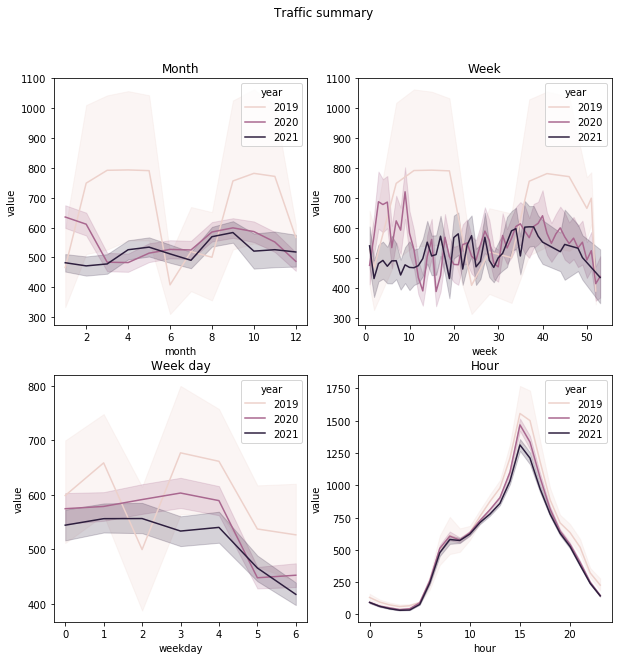

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=False)
fig.suptitle('Traffic summary')

sns.lineplot(ax=axes[0,0], x='month',y='value',hue='year',data=one_direction)
axes[0,0].set_title('Month')

sns.lineplot(ax=axes[0,1], x='week',y='value',hue='year',data=one_direction)
axes[0,1].set_title('Week')

sns.lineplot(ax=axes[1,0], x='weekday',y='value',hue='year',data=one_direction)
axes[1,0].set_title('Week day')

sns.lineplot(ax=axes[1,1], x='hour',y='value',hue='year',data=one_direction)
axes[1,1].set_title('Hour')


As we can see different granularity in the scale gives us quite different results. Features such as the year, the month, the week of the year, the week day and the hour can have a big impact on the number of cars on the road.

## Modelling
Now that we have a good picture of the data, let's start to see if we can find a good fit.

It's important to note that since we are dealing with time series data, we can not blindly form train and test splits randomly.
We have to respect the structure of the data and only test on future samples.

In [60]:
# Let's divide the data into input features (X) and target features (y)
input_features = ['direction', 'hour', 'holiday', 'year', 'month', 'week', 'weekday', 'day', 'is_weekend']
target_feature = ['value']
X = np.array(data[input_features])
y = np.array(data[target_feature])
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (32160, 9)
Shape of y: (32160, 1)


In [63]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [   0    1    2 ... 5357 5358 5359] TEST: [ 5360  5361  5362 ... 10717 10718 10719]
TRAIN: [    0     1     2 ... 10717 10718 10719] TEST: [10720 10721 10722 ... 16077 16078 16079]
TRAIN: [    0     1     2 ... 16077 16078 16079] TEST: [16080 16081 16082 ... 21437 21438 21439]
TRAIN: [    0     1     2 ... 21437 21438 21439] TEST: [21440 21441 21442 ... 26797 26798 26799]
TRAIN: [    0     1     2 ... 26797 26798 26799] TEST: [26800 26801 26802 ... 32157 32158 32159]


As we can see `TimeSeriesSplit` respects the direction of time and does not leak data into the test set.

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

mae_train = []
mae_percentage = []
for train_index, test_index in tscv.split(X):
    # Get the train and test data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the linear regression model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # See model performance
    predictions_train = lin_reg.predict(X_train)
    predictions_test = lin_reg.predict(X_test)
    print("MAE (train) = ", mean_absolute_error(y_train, predictions_train))
    print("MAE (test) = ", mean_absolute_error(y_test, predictions_test))

MAE (train) =  375.25645156823384
MAE (test) =  319.808383983027
MAE (train) =  343.9743935524636
MAE (test) =  347.88643987819285
MAE (train) =  345.1829453737772
MAE (test) =  322.23723155798444
MAE (train) =  339.5280087692909
MAE (test) =  310.10266619752747
MAE (train) =  334.11886491135147
MAE (test) =  320.56505031681417


We need to use the negative mean absolute error because for cross validation scores in sklearn higher is always better.

In [96]:
lin_reg = LinearRegression()
cv_score_mae = cross_val_score(lin_reg, X, y, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_score_mape = cross_val_score(lin_reg, X, y, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
cv_score_r2 = cross_val_score(lin_reg, X, y, cv=tscv, scoring='r2', n_jobs=-1)

In [97]:
cv_score_mae, cv_score_mape, cv_score_r2, cv_score_r2.mean()

(array([-319.80838398, -347.88643988, -322.23723156, -310.1026662 ,
        -320.56505032]),
 array([-3.04776237, -2.17971458, -2.91738494, -2.44737318, -2.38843258]),
 array([0.08896215, 0.08991472, 0.12124327, 0.13060835, 0.13345494]),
 0.11283668857457108)

In [93]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
cv_score_mae = cross_val_score(rf_reg, X, y, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
cv_score_mape = cross_val_score(rf_reg, X, y, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
cv_score_r2 = cross_val_score(rf_reg, X, y, cv=tscv, scoring='r2', n_jobs=-1)

In [94]:
cv_score_mae, cv_score_mape, cv_score_r2, cv_score_r2.mean()

(array([-137.18759142, -102.35439925, -136.32971269,  -90.97813806,
         -83.21967351]),
 array([-0.58222674, -0.30812722, -0.45824072, -0.26096853, -0.27144183]),
 array([0.69787423, 0.83299052, 0.71215848, 0.85032182, 0.8708201 ]),
 0.792833031849233)

As we can see a random forest regressor can outperform without any hyperparameter tuning to a linear regression model. However, both models perform fairly good.

In [84]:
cv_score_mape = cross_val_score(rf_reg, X, y, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)


In [92]:
cv_score_r2 = cross_val_score(rf_reg, X, y, cv=tscv, scoring='r2', n_jobs=-1)
cv_score_r2

array([0.70435334, 0.84357613, 0.71325126, 0.84873202, 0.87461968])

In [85]:
cv_score_mape

array([-53369.05529019, -35545.26555963, -50195.7473114 , -24575.70239886,
       -22030.49326228])

In [98]:
137.2/y.max()*100

5.716666666666667